Fold 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.132383
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.132383
  Лучший порог: 0.537 с F1 = 0.9418 и Accuracy = 0.9698
Fold 2
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.141158
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.141158
  Лучший порог: 0.349 с F1 = 0.9358 и Accuracy = 0.9668
Fold 3
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.143314
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.143314
  Лучший порог: 0.431 с F1 = 0.9347 и Accuracy = 0.9663
Fold 4
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.131579
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.131579
  Лучший порог: 0.659 с F1 = 0.9432 и Ac

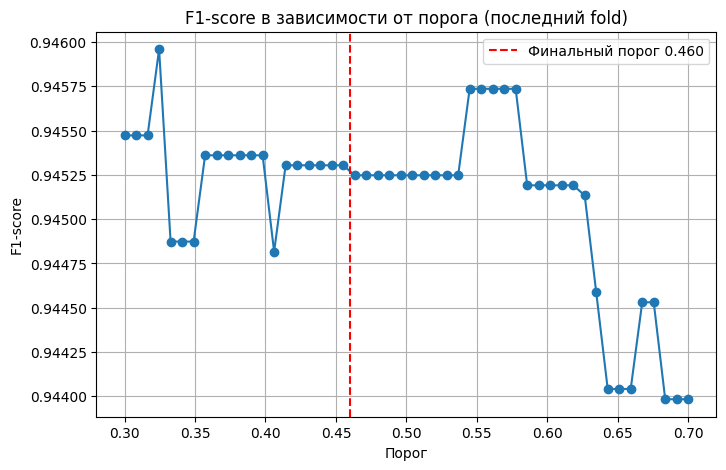

/Users/antontravkin/Sites/python_rtk/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


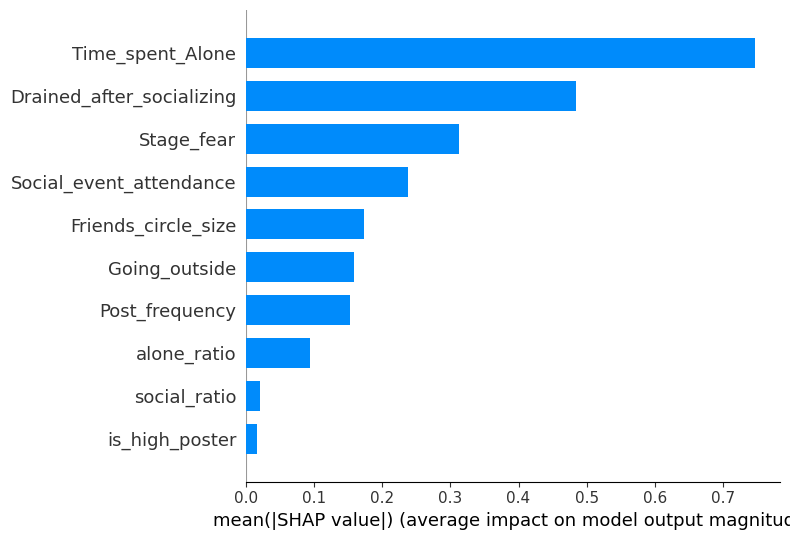

In [3]:
import zipfile
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.metrics import f1_score, accuracy_score

# --- Распаковка и загрузка данных ---
with zipfile.ZipFile('playground-series-s5e7.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# --- Feature Engineering ---
for df in [df_train, df_test]:
    df['alone_ratio'] = df['Time_spent_Alone'] / \
        (df['Time_spent_Alone'] +
         df['Social_event_attendance'] + df['Going_outside'] + 1)
    df['social_ratio'] = df['Social_event_attendance'] / \
        (df['Going_outside'] + 1)
    df['is_high_poster'] = (df['Post_frequency'] > 5).astype(int)

# --- Кодируем таргет ---
target = 'Personality'
label_encoder = LabelEncoder()
df_train['target'] = label_encoder.fit_transform(df_train[target])

num_features = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
                'Friends_circle_size', 'Post_frequency', 'alone_ratio', 'social_ratio']
cat_features = ['Stage_fear', 'Drained_after_socializing', 'is_high_poster']

X = df_train[num_features + cat_features]
y = df_train['target']
X_test = df_test[num_features + cat_features]

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder())
])
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features)
])

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'random_state': 42,
    'learning_rate': 0.03,  # Меньше скорость обучения
    'num_leaves': 31,
    'max_depth': 5,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 1,
    'lambda_l2': 1
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
probas = np.zeros(len(X_test))
best_thresholds = []
val_f1_scores = []
val_acc_scores = []

thresholds = np.linspace(0.3, 0.7, 50)

# Для построения графика F1 vs Threshold на последнем фолде
last_fold_f1s = []
last_fold_thresholds = []

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold+1}")
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]

    X_train_prep = preprocessor.fit_transform(X_train, y_train)
    X_valid_prep = preprocessor.transform(X_valid)
    X_test_prep = preprocessor.transform(X_test)

    train_data = lgb.Dataset(X_train_prep, label=y_train)
    valid_data = lgb.Dataset(X_valid_prep, label=y_valid)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
    )

    val_pred_proba = model.predict(X_valid_prep)

    best_f1, best_thr = 0, 0.5
    f1s = []
    for thr in thresholds:
        preds = (val_pred_proba > thr).astype(int)
        f1 = f1_score(y_valid, preds)
        f1s.append(f1)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr

    preds_best_thr = (val_pred_proba > best_thr).astype(int)
    acc = accuracy_score(y_valid, preds_best_thr)

    print(
        f"  Лучший порог: {best_thr:.3f} с F1 = {best_f1:.4f} и Accuracy = {acc:.4f}")

    best_thresholds.append(best_thr)
    val_f1_scores.append(best_f1)
    val_acc_scores.append(acc)

    probas += model.predict(X_test_prep) / skf.n_splits

    if fold == skf.get_n_splits() - 1:
        last_fold_f1s = f1s
        last_fold_thresholds = thresholds

print(f"\nСредний F1 по валидации: {np.mean(val_f1_scores):.4f}")
print(f"Средняя Accuracy по валидации: {np.mean(val_acc_scores):.4f}")

final_thr = np.mean(best_thresholds)
print(f"Используем финальный усреднённый порог: {final_thr:.3f}")

preds_final = (probas > final_thr).astype(int)
df_test['Personality'] = label_encoder.inverse_transform(preds_final)
df_test[['id', 'Personality']].to_csv('submission.csv', index=False)
print("✅ Готово: submission.csv создан с оптимизированным порогом.")

# --- График F1 vs Threshold для последнего фолда ---
plt.figure(figsize=(8, 5))
plt.plot(last_fold_thresholds, last_fold_f1s, marker='o')
plt.axvline(final_thr, color='r', linestyle='--',
            label=f'Финальный порог {final_thr:.3f}')
plt.title('F1-score в зависимости от порога (последний fold)')
plt.xlabel('Порог')
plt.ylabel('F1-score')
plt.legend()
plt.grid(True)
plt.show()

# --- SHAP анализ важности признаков ---
explainer = shap.TreeExplainer(model)
X_train_full_prep = preprocessor.transform(X)  # препроцессим весь train для SHAP
shap_values = explainer.shap_values(X_train_full_prep)

shap.summary_plot(shap_values, X_train_full_prep,
                  feature_names=num_features + cat_features, plot_type='bar')

In [8]:
#!kaggle competitions submit -c playground-series-s5e7 -f submission.csv -m "1 commit"